
#Universidad de Las Palmas de Gran Canaria.

Máster Universitario en Sistemas Inteligentes y Aplicaciones Numéricas en Ingeniería.

Computación Inteligente.

Nisrine El Allaoui





#Título:
Clasificación de Personajes de Los Simpson con Redes Neuronales
#Descripción:
Este proyecto utiliza un conjunto de datos de imágenes de seis personajes de la serie "Los Simpson". A través de una red neuronal, se busca clasificar correctamente a cada personaje en función de sus características visuales.


#Dependencias y Configuración del Entorno
En este bloque, se importan las bibliotecas necesarias para implementar y entrenar una red neuronal. Las principales dependencias utilizadas son:


*   PyTorch: Para construir, entrenar y evaluar la red neuronal.
*   torchvision: Para trabajar con datasets e implementar transformaciones en las imágenes.
*   Matplotlib: Para visualizar datos y resultados.



Código:

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim


print('\nVersion torch:', torch.__version__)


Version torch: 2.5.1+cu121




#Configuración del Dispositivo
En esta sección, se verifica si hay una GPU disponible para aprovechar la aceleración de hardware durante el entrenamiento del modelo. Si no se detecta una GPU, se utilizará la CPU. Esto asegura que el código sea adaptable a diferentes entornos de ejecución.

Código:



In [7]:

# Configuración del dispositivo (usa GPU si está disponible)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Cuda está disponible. Se utilizará la GPU del equipo')
else:
    device = torch.device("cpu")
    print('Cuda no está disponible. Se utilizará la CPU del equipo')

Cuda está disponible. Se utilizará la GPU del equipo


#Preparación de los Datos
En esta sección, se realiza la preprocesamiento de las imágenes para que sean compatibles con la red neuronal:

* Redimensionamiento: Se ajusta el tamaño de las imágenes a 128x128 píxeles para uniformidad.
* Conversión a Tensores: Se convierten las imágenes en tensores para que puedan ser procesadas por PyTorch.
* Normalización: Se escala el rango de píxeles de las imágenes a valores entre -1 y 1, lo que acelera el entrenamiento y mejora la estabilidad numérica.


Detalles del proceso de normalización:


1.   Fórmula de normalización:
      
      La normalización en PyTorch se aplica pixel a pixel usando la fórmula:

      Valor_normalizado = (Valor_original−mean)/std

2.   Parámetros utilizados:

      mean=[0.5, 0.5, 0.5]: Indica que el promedio para   cada canal (R, G, B) es 0.5.
      std=[0.5, 0.5, 0.5]: Establece que la desviación estándar para cada canal es 0.5.

3.  Cómo funciona para imágenes en el rango [0, 1]:

    Si los valores iniciales de los píxeles están en el rango
    [0,1], el cálculo sería:

    Valor normalizado= (Valor original−0.5)/0.5


Esto transforma los valores:

0 (negro) → −1

0.5 (gris medio) → 0

1 (blanco) → 1
Por lo tanto, escala los valores originales de [0, 1] al rango [-1, 1].

Código:

In [8]:

transform = transforms.Compose([
    transforms.Resize((128, 128)), # Iguala el tamaño de las imágees
    transforms.ToTensor(), # Convierte las imágenes a tensores
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Escala a -1;1
])

Descripción del Dataset: El conjunto de datos se organiza utilizando ImageFolder, que permite trabajar con datos almacenados en carpetas. Cada subcarpeta representa una clase (en este caso, un personaje de Los Simpson).



In [9]:
dataset = datasets.ImageFolder('/content/drive/MyDrive/data', transform=transform)

#Exploración del Conjunto de Datos
Antes de entrenar el modelo, es importante entender la distribución del conjunto de datos. En este bloque de código:

* Número total de imágenes: Se imprime la cantidad total de imágenes disponibles en el dataset.

* Número de clases: Se identifica cuántas clases diferentes (en este caso, personajes de Los Simpson) hay en el dataset.

* Distribución por clase: Se calcula el porcentaje de imágenes asociadas a cada clase, proporcionando una visión general del balance de datos.

In [10]:
# Exploración de datos.

print("Número de imágenes: ", len(dataset))
print("Número de clases: ", len(dataset.classes), "\n")
import os

for i in range(len(dataset.classes)):
    # Use os.path.join to create the full path for each class folder
    class_path = os.path.join('/content/drive/MyDrive/data', dataset.classes[i])
    class_count = len(os.listdir(class_path))  # Get the number of images in each class folder
    class_percentage = round((class_count / len(dataset)) * 100, 2)  # Calculate the percentage

    print(f"Clase {i}: {dataset.classes[i]} - {class_percentage}%")


Número de imágenes:  7014
Número de clases:  6 

Clase 0: abraham_grampa_simpson - 13.3%
Clase 1: bart_simpson - 19.13%
Clase 2: charles_montgomery_burns - 17.01%
Clase 3: chief_wiggum - 14.06%
Clase 4: krusty_the_clown - 17.19%
Clase 5: lisa_simpson - 19.3%


### Separación del Conjunto de Datos
Para entrenar y evaluar el modelo de manera efectiva, el conjunto de datos se divide en tres subconjuntos:

* Entrenamiento (80%)
* Validación (10%)
* Prueba (10%)

La función random_split se utiliza para dividir aleatoriamente el dataset según los tamaños especificados.

Código:

In [11]:
# Separación de datos en entrenamiento y prueba.

train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
remaining_size = len(dataset) - train_size  # El 20% restante
test_size = int(0.5 * remaining_size)  # La mitad para prueba (10%)
val_size = remaining_size - test_size  # La otra mitad para validación (10%)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(test_dataset)}")
print(f"Test data size: {len(val_dataset)}")



Training data size: 5611
Validation data size: 701
Test data size: 702


#Visualización de Imágenes y Etiquetas

Antes de entrenar el modelo, es útil inspeccionar visualmente algunas imágenes del conjunto de datos. Esto permite verificar que las etiquetas asociadas sean correctas y que las transformaciones aplicadas durante el preprocesamiento no hayan alterado las imágenes de manera no deseada.

En este bloque de código:

1. Se define una función show_img para visualizar una imagen junto con su etiqueta.
2. Se selecciona una imagen del conjunto de datos de entrenamiento para ser mostrada.
3. La etiqueta correspondiente se imprime junto con el nombre de la clase y su índice.

Código:

Label:  krusty_the_clown (4)


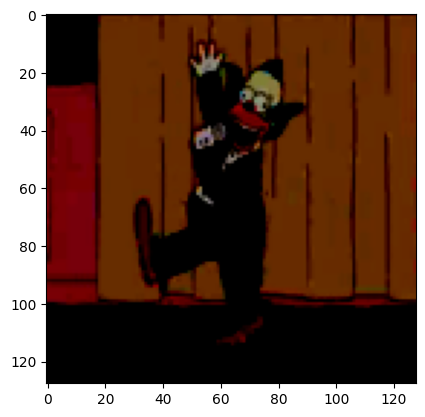

In [12]:
# Muestra una imagen de prueba y su etiqueta

def show_img(img, label):
    print('Label: ', dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

img, label = train_dataset[3]
show_img(img, label)

#Creación de DataLoaders
Los DataLoaders se utilizan para cargar los datos de manera eficiente durante el entrenamiento y la evaluación del modelo. En este caso:

1. Conjuntos de datos:

    * train_loader: Contiene los datos de entrenamiento, cargados en mini-batches con aleatorización (shuffle=True).
    * val_loader: Contiene los datos de validación, cargados sin aleatorización (shuffle=False).
    * test_loader: Contiene los datos de prueba, también cargados sin aleatorización.

2. Tamaño de lote (batch size): Cada mini-batch contiene 32 imágenes, lo que es un tamaño común para balancear eficiencia y rendimiento.

3. Inspección de un lote: Se extrae un lote del conjunto de prueba (test_loader) y se imprime la forma del tensor de imágenes y etiquetas, lo que ayuda a verificar que los datos se estén cargando correctamente.

In [13]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:

batch = next(iter(test_loader))
print(batch[0].shape, batch[1].shape)


torch.Size([32, 3, 128, 128]) torch.Size([32])


Explicación de la Salida:

torch.Size([32, 3, 128, 128]): Indica que el lote contiene 32 imágenes, cada una con 3 canales (RGB) y dimensiones de 128x128 píxeles.

torch.Size([32]): Indica que hay 32 etiquetas correspondientes a las imágenes del lote.

# Arquitectura de la red
El modelo utilizado se basa en una red neuronal convolucional sencilla (SimpleCNN), diseñada para procesar imágenes y clasificar a los personajes de Los Simpson. La arquitectura se define con las siguientes características:

## Capas del modelo
* Entrada:

    Tensor de dimensión 3 x 128 x 128 (canales de color RGB x tamaño de la imagen
    en píxeles).

* Capas convolutivas:

   * Aplican kernels de tamaño 3×3, avanzando de píxel en píxel (𝑠𝑡𝑟𝑖𝑑𝑒=1) con relleno en los bordes (padding=1) para mantener el tamaño espacial.
   * Capa 1: Conv2D con 3 canales de entrada (RGB) y 32 canales de salida.
   * Capa 2: Conv2D con 32 canales de entrada (de la capa anterior) y 64 canales de salida.
   * Ambas capas convolutivas están seguidas por:
      * Una activación ReLU.
      * Una operación de MaxPooling para reducir las dimensiones espaciales.


* Pooling:
    
    * Reduce la dimensionalidad extrayendo características relevantes.

    * MaxPooling con un kernel 2×2 y stride 2, lo que reduce las dimensiones  
      espaciales a la mitad en cada paso.

    * Ejemplo de transformación:

        * Después de conv1 y pooling: 32×32→32×16×16.
        * Después de conv2 y pooling: 64×16×16→64×8×8.  

* Flatten:

     * Convierte el tensor tridimensional de salida (64×8×8) en un vector unidimensional.
     * Ejemplo: Transformación de 64×8×8 a un vector de 4096 elementos.


* Linealización (fc1):

     * Una capa completamente conectada que reduce la dimensionalidad de 4096 a
128.
     * Activación mediante ReLU.

* Dropout:

    Omite aleatoriamente 50% de las neuronas durante el entrenamiento para mejorar la generalización y reducir el sobreajuste.

* Capa de salida (fc2):

    Capa fully connected que reduce la dimensionalidad de 128 a 6, correspondiente al número de categorías (personajes).


## Funciones clave

  **ReLU (Rectified Linear Unit):**
    Filtra valores negativos en las capas convolutivas y fully connected.
    Introduce no linealidad a la red, permitiendo el aprendizaje de representaciones más complejas.

   **Dropout:**
    Apaga neuronas de forma aleatoria durante el entrenamiento, promoviendo la robustez del modelo.

## Resumen de flujo de datos:

  **Entrada:** 3 x 128 x 128 (imagen RGB).

   **Capa 1:** convolutiva (32 canales) + activación ReLU + pooling → 32 x 64 x 64.

   **Capa 2:** convolutiva (64 canales) + activación ReLU + pooling → 64 x 32 x 32.

   **Flatten:** vectoriza → 65636 elementos.

   **Fully connected (fc1):** reduce a 128 con Dropout.

   **Fully connected (fc2):** reduce a 6 (clases finales).


In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 64, 128)
        self.fc2 = nn.Linear(128, 6)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten dinámico
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Configuración del Modelo, Función de Pérdida y Optimizador
En esta parte se define cómo se entrenará el modelo, estableciendo:

1. El modelo utilizado.
2. La función de pérdida: para evaluar el error durante el entrenamiento.
3. El optimizador: para ajustar los parámetros del modelo y minimizar el error.

## Modelo
* Se crea una instancia del modelo definido previamente (SimpleCNN) y se transfiere al dispositivo disponible (GPU o CPU) para aprovechar recursos de hardware.

* La línea model.to(device) asegura que todas las operaciones se ejecuten en el dispositivo especificado.

## Función de Pérdida
* Se utiliza CrossEntropyLoss, una función de pérdida estándar para tareas de clasificación.

* Calcula la diferencia entre las predicciones del modelo y las etiquetas reales, proporcionando un valor escalar que el optimizador intentará minimizar.

## Optimizador
* Se utiliza el optimizador Adam (Adaptive Moment Estimation).

* El argumento model.parameters() asegura que todos los parámetros entrenables del modelo sean actualizados durante el entrenamiento.

* La tasa de aprendizaje (lr=0.001) es un hiperparámetro clave que determina la magnitud de los ajustes en cada iteración.


In [16]:
# Función de pérdida y optimizador
model = SimpleCNN()         # Crea el modelo
model = model.to(device)    # Utiliza la GPU si está disponible

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del Modelo

En este bloque se implementa el proceso de entrenamiento de la red neuronal convolucional utilizando el conjunto de datos previamente definido. A continuación, se describen las partes clave:

## Configuración del Entrenamiento
* Modelo:

  Se transfiere el modelo (SimpleCNN) al dispositivo disponible (GPU o CPU) para ejecutar las operaciones de manera eficiente.

* Función de pérdida:

  Se utiliza CrossEntropyLoss, que mide el error entre las predicciones del modelo y las etiquetas reales.

* Optimizador:

  Adam es seleccionado por su eficiencia en la convergencia, ajustando los parámetros del modelo con una tasa de aprendizaje inicial (lr=0.001).

* Scheduler:

  StepLR reduce la tasa de aprendizaje en un factor (gamma=0.5) cada 5 épocas (step_size=5). Esto mejora la estabilidad en etapas avanzadas del entrenamiento.

# Proceso de Entrenamiento
El entrenamiento se realiza durante 10 épocas (num_epochs) y consta de dos fases principales en cada iteración:

### Fase 1: Entrenamiento
* El modelo pasa al modo de entrenamiento (model.train()).
* Para cada lote (batch) en train_loader:
* Los datos y etiquetas se transfieren al dispositivo.
* Se calculan las predicciones del modelo.
* Se calcula la pérdida (error) entre las predicciones y las etiquetas reales.
* Se realiza la retropropagación para ajustar los parámetros del modelo.
* Se acumula la pérdida y se calcula la precisión del lote.

### Resultados al final de la época:

* Pérdida acumulada: Indicador del error en el conjunto de entrenamiento.
* Precisión: Porcentaje de imágenes correctamente clasificadas.

### Fase 2: Validación
El modelo pasa al modo de evaluación (model.eval()), desactivando Dropout.
Se calcula la pérdida y precisión en el conjunto de validación sin realizar ajustes en los parámetros (modo no gradiente).

## Guardado del Modelo
Al final del entrenamiento, los pesos del modelo se guardan en un archivo .pth para reutilización o evaluación futura.

In [26]:
# Modelo, pérdida y optimizador
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Entrenamiento del modelo
num_epochs = 10

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Actualizar el programador de tasa de aprendizaje
    scheduler.step()

# Guardar el modelo
model_path = "/content/drive/MyDrive/data/model29122024.pth"
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado en {model_path}")


Epoch [1/10], Loss: 223.6880, Accuracy: 50.95%
Validation Loss: 18.7717, Accuracy: 70.51%
Epoch [2/10], Loss: 149.0176, Accuracy: 68.37%
Validation Loss: 15.9135, Accuracy: 72.79%
Epoch [3/10], Loss: 120.9324, Accuracy: 74.26%
Validation Loss: 13.1514, Accuracy: 77.21%
Epoch [4/10], Loss: 97.3396, Accuracy: 79.40%
Validation Loss: 12.5590, Accuracy: 77.92%
Epoch [5/10], Loss: 74.3132, Accuracy: 84.28%
Validation Loss: 12.0648, Accuracy: 81.20%
Epoch [6/10], Loss: 50.4324, Accuracy: 90.39%
Validation Loss: 11.8054, Accuracy: 84.05%
Epoch [7/10], Loss: 37.4096, Accuracy: 92.25%
Validation Loss: 11.9653, Accuracy: 84.19%
Epoch [8/10], Loss: 28.8083, Accuracy: 93.92%
Validation Loss: 12.7597, Accuracy: 84.19%
Epoch [9/10], Loss: 23.1361, Accuracy: 95.56%
Validation Loss: 14.6484, Accuracy: 84.05%
Epoch [10/10], Loss: 20.2276, Accuracy: 95.99%
Validation Loss: 13.8977, Accuracy: 84.62%
Modelo guardado en /content/drive/MyDrive/data/model29122024.pth


## Testeo del Modelo

En esta sección, se evalúa el rendimiento final del modelo en el conjunto de datos de prueba (test set). Esto es crucial para medir la capacidad del modelo de generalizar en datos no vistos previamente.

1. Carga del Modelo Entrenado:

    * Se cargan los pesos del modelo guardados durante el entrenamiento utilizando torch.load().
    * El modelo se coloca en modo de evaluación (model.eval()) para desactivar comportamientos como Dropout, asegurando predicciones consistentes.

2. Evaluación en el Conjunto de Prueba:

    * Se itera a través del test_loader para calcular las métricas:
        * Pérdida (Loss): Error promedio entre las predicciones del modelo y las etiquetas reales.
        * Precisión (Accuracy): Porcentaje de imágenes correctamente clasificadas.

3. Desactivación del Gradiente:

      El bloque with torch.no_grad() asegura que no se calculen gradientes, lo que ahorra memoria y acelera el proceso.


In [27]:
model_path = "/content/drive/MyDrive/data/model29122024.pth"
# Testeo del modelo
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    test_accuracy = 100. * correct / total
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


<ipython-input-27-1908c339f99d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 17.6341, Accuracy: 79.03%


# Proceso de Entrenamiento con Transfer Learning

El uso de transfer learning se basa en aprovechar un modelo preentrenado, como ResNet18, que ya ha aprendido características generales útiles en tareas de visión por computadora. Esto permite entrenar de manera más eficiente y con mejores resultados en conjuntos de datos específicos.

Configuración del Modelo
* Modelo Preentrenado: ResNet18 con pesos iniciales de ImageNet (pretrained=True), lo que permite reutilizar características previamente aprendidas como bordes, texturas y formas.

* Modificación de la Capa de Salida: La última capa completamente conectada (fc) se reemplaza para que el modelo sea capaz de clasificar en las categorías específicas del conjunto de datos actual.

* Capas Congeladas: Las capas iniciales (excepto layer4 y fc) están congeladas para evitar la actualización de sus pesos durante el entrenamiento, lo que conserva las características generales aprendidas en el modelo base.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# Cargar modelo preentrenado (ResNet18 en este caso)
model = models.resnet18(pretrained=True)

# Congelar capas iniciales excepto las últimas
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:  # Ajusta según tu arquitectura
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modificar la última capa completamente conectada
num_classes = 6  # Cambia según tu conjunto de datos
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Mover el modelo al dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Entrenamiento y validación
num_epochs = 10
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Ajustar el scheduler
    scheduler.step(val_loss)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 127.8928, Accuracy: 75.12%
Validation Loss: 6.7208, Accuracy: 90.17%
Epoch [2/10], Loss: 40.1775, Accuracy: 93.33%
Validation Loss: 4.8946, Accuracy: 92.17%
Epoch [3/10], Loss: 21.7007, Accuracy: 96.81%
Validation Loss: 4.1365, Accuracy: 94.59%
Epoch [4/10], Loss: 12.3676, Accuracy: 98.34%
Validation Loss: 4.2108, Accuracy: 94.16%
Epoch [5/10], Loss: 7.7720, Accuracy: 99.36%
Validation Loss: 3.9947, Accuracy: 94.59%
Epoch [6/10], Loss: 4.8303, Accuracy: 99.73%
Validation Loss: 3.9227, Accuracy: 94.44%
Epoch [7/10], Loss: 4.2713, Accuracy: 99.64%
Validation Loss: 3.8101, Accuracy: 94.87%
Epoch [8/10], Loss: 2.9180, Accuracy: 99.89%
Validation Loss: 3.9575, Accuracy: 95.16%
Epoch [9/10], Loss: 3.4610, Accuracy: 99.73%
Validation Loss: 3.7884, Accuracy: 94.87%
Epoch [10/10], Loss: 2.2702, Accuracy: 99.84%
Validation Loss: 4.1139, Accuracy: 94.73%


In [29]:
torch.save(model.state_dict(), "/content/drive/MyDrive/data/model_transfer_learning2.pth")
print("Modelo guardado como model_transfer_learning.pth")


Modelo guardado como model_transfer_learning.pth


In [32]:
model_path="/content/drive/MyDrive/data/model_transfer_learning2.pth"
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    test_accuracy = 100. * correct / total
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


<ipython-input-32-4827f5373331>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 4.4709, Accuracy: 92.87%
